In [40]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%load_ext autoreload
%autoreload 2
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np
import calendar
import re
from nltk.tokenize import word_tokenize , sent_tokenize
from spellchecker import SpellChecker
import pyphen
import string
import json
from classifiers import *
from regression import *
from utils import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
import lightgbm as lgb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
data = pd.read_csv("datasets/final_freq_months_days_ids_adjusted.csv",engine='python',error_bad_lines=False)

(array([1.3912e+04, 7.5980e+03, 6.3030e+03, 4.4550e+03, 5.6130e+03,
        2.5520e+03, 1.8130e+03, 2.4880e+03, 1.0530e+03, 3.8650e+03,
        6.4700e+02, 1.2000e+03, 6.4600e+02, 3.8100e+02, 2.1640e+03,
        4.9500e+02, 4.0600e+02, 4.2700e+02, 2.3900e+02, 1.6880e+03,
        1.4000e+02, 2.3400e+02, 2.4200e+02, 2.0100e+02, 1.4090e+03,
        1.3900e+02, 1.5300e+02, 1.6300e+02, 8.8000e+01, 1.0410e+03,
        8.4000e+01, 1.2400e+02, 1.1800e+02, 1.0100e+02, 4.5300e+02,
        9.2000e+01, 7.4000e+01, 9.6000e+01, 9.9000e+01, 4.3500e+02,
        3.5000e+01, 5.9000e+01, 3.5000e+01, 4.2000e+01, 4.9000e+01,
        1.9400e+02, 4.7000e+01, 4.5000e+01, 5.2000e+01, 4.1000e+01,
        1.1380e+03, 2.5000e+01, 4.9000e+01, 2.9000e+01, 5.4000e+01,
        1.1700e+02, 3.9000e+01, 3.6000e+01, 2.8000e+01, 2.4000e+01,
        2.2900e+02, 2.1000e+01, 2.4000e+01, 1.6000e+01, 1.9000e+01,
        1.0000e+02, 2.0000e+01, 1.1000e+01, 2.0000e+01, 1.4000e+01,
        1.0100e+02, 9.0000e+00, 2.5000e+01, 5.00

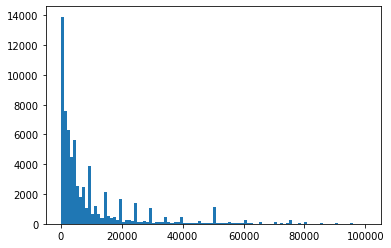

In [42]:
plt.hist(data[data['usd_goal_real']<100000]['usd_goal_real'],bins=100,stacked=False)

Log scale the attributes

In [4]:
data['usd_pledged_real']=np.log(1+data['usd_pledged_real'])
data['usd_goal_real']=np.log(1+data['usd_goal_real'])
data['mean_category_goal']=np.log(1+data['mean_category_goal'])
data['mean_main_category_goal']=np.log(1+data['mean_main_category_goal'])
# data['creator_successful']=np.log(1+data['creator_successful'])
# data['imageCount']=np.log(1+data['imageCount'])

Drop the features we don't need

In [5]:
data.to_csv('mynewcsv.csv',index=False)
filtered_data=data.drop(["category_count","main_category_count","no_video","diff_mean_category_goal","diff_mean_main_category_goal","no_weekend","id"],axis=1)

collinear_features = ['cTotal', 'aboutNumSents', 'risksNumSents']
low_importance_class =   ['yes_video', 'cSuccess', 'blurbMaxSyllables', 'risksMaxSyllables', 'blurbNumSents', 'yes_weekend']
filtered_data = filtered_data.drop(collinear_features,axis=1)
filtered_data = filtered_data.drop(low_importance_class,axis=1)
# filtered_data=filtered_data.drop(["mean_category_goal","mean_main_category_goal"],axis=1)

In [6]:

pd.set_option('display.max_columns', None)
filtered_data.describe()

,usd_goal_real,state,usd_pledged_real,imageCount,category_freq,main_category_freq,country_freq,month_sine,day_sine,duration,mean_category_goal,mean_main_category_goal,blurbNumWords,blurbAvgSentLength,blurbSpellingErrors,aboutNumWords,aboutAvgSentLength,aboutMaxSyllables,aboutSpellingErrors,risksNumWords,risksAvgSentLength,risksSpellingErrors
count,69210.000000,69210.000000,69210.000000,69210.000000,69210.000000,69210.000000,69210.000000,6.921000e+04,69210.000000,69210.000000,69210.000000,69210.000000,69210.000000,69210.000000,69210.000000,69210.000000,69210.000000,69210.000000,69210.000000,69210.000000,69210.000000,69210.000000
mean,8.388462,0.288253,6.903427,15.402138,0.011367,0.094184,0.550227,-2.740032e-02,0.208041,30.982748,9.787968,10.162840,22.029866,9.240045,1.315937,714.737740,21.889740,5.788296,24.704595,123.752160,17.298250,3.611877
std,1.723251,0.957561,3.064463,20.147226,0.005724,0.044301,0.298035,7.195794e-01,0.650343,10.884428,1.200030,0.999731,5.416173,2.626179,1.629904,687.750304,7.686712,2.879069,41.731381,111.411897,6.042516,8.824637
min,0.553885,-1.000000,0.000000,0.000000,0.000014,0.021370,0.000101,-1.000000e+00,-0.974928,0.000000,7.586130,8.820326,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000
25%,7.313887,-1.000000,5.624018,4.000000,0.006531,0.048866,0.114246,-8.660254e-01,-0.433884,29.000000,8.874149,9.129817,19.000000,7.500000,0.000000,253.000000,17.750000,5.000000,7.000000,57.000000,13.571429,1.000000
50%,8.517393,1.000000,7.666690,8.000000,0.011920,0.110302,0.730588,-2.449294e-16,0.433884,29.000000,9.502993,10.219383,23.000000,9.000000,1.000000,498.000000,21.062500,5.000000,15.000000,96.000000,17.000000,2.000000
75%,9.449436,1.000000,8.950803,18.000000,0.015908,0.143130,0.730588,8.660254e-01,0.781831,32.000000,10.678948,10.925803,26.000000,11.000000,2.000000,946.000000,24.941176,6.000000,28.000000,156.000000,20.600000,4.000000
max,18.835409,1.000000,15.661331,332.000000,0.021760,0.151582,0.730588,1.000000e+00,0.974928,89.000000,14.214930,11.600327,44.000000,18.500000,16.000000,9411.000000,342.166667,180.000000,1354.000000,5703.000000,131.500000,547.000000


In [7]:
# train, test = train_test_split(filtered_data, test_size=0.2,random_state=206)
# train.to_csv('fresh_train_206_5.csv',index=False)
# test.to_csv('fresh_test_206_5.csv',index=False)

train=pd.read_csv("fresh_train_206_5.csv",engine='python',error_bad_lines=False)
test=pd.read_csv("fresh_test_206_5.csv",engine='python',error_bad_lines=False)

In [8]:
trainValues=train.drop(['state','usd_pledged_real'],axis=1)
targetValues=train['state']
regressionTrainValues=train['usd_pledged_real']
testValues=test.drop(['state','usd_pledged_real'],axis=1)
testTargetValues=test['state']
regressionTestValues=test['usd_pledged_real']

trainValues.columns

Index(['usd_goal_real', 'imageCount', 'category_freq', 'main_category_freq',
       'country_freq', 'month_sine', 'day_sine', 'duration',
       'mean_category_goal', 'mean_main_category_goal', 'blurbNumWords',
       'blurbAvgSentLength', 'blurbSpellingErrors', 'aboutNumWords',
       'aboutAvgSentLength', 'aboutMaxSyllables', 'aboutSpellingErrors',
       'risksNumWords', 'risksAvgSentLength', 'risksSpellingErrors'],
      dtype='object')

In [9]:
clf=call_gradientboosting_reg(trainValues,regressionTrainValues)
pred=clf.predict(trainValues)
res = np.zeros(pred.shape)
res[pred>=train['usd_goal_real']] = 1
res[pred<train['usd_goal_real']] = -1
print(np.sum(res==train['state'])/len(train))

pred=clf.predict(testValues)
res = np.zeros(pred.shape)
res[pred>=test['usd_goal_real']] = 1
res[pred<test['usd_goal_real']] = -1
print(np.sum(res==test['state'])/len(test))

0.665149544863459
0.6644271059095507


In [10]:
# d_train = lgb.Dataset(trainValues, label=targetValues)
# params = {}
# params['learning_rate'] = 0.003
# params['boosting_type'] = 'gbdt'
# params['objective'] = 'binary'
# params['metric'] = 'binary_logloss'
# params['sub_feature'] = 0.5
# params['num_leaves'] = 10
# params['min_data'] = 50
# params['max_depth'] = 10
# clf = lgb.train(params, d_train, 100)

In [11]:
# np.max(clf.predict(testValues))

In [12]:
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(trainValues, targetValues)
clf.score(testValues, testTargetValues)
classification_report(clf.predict(testValues),testTargetValues,output_dict=True)

/home/nic/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


{'-1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 '1': {'precision': 1.0,
  'recall': 0.6486779367143476,
  'f1-score': 0.7869067963717629,
  'support': 13842},
 'accuracy': 0.6486779367143476,
 'macro avg': {'precision': 0.5,
  'recall': 0.3243389683571738,
  'f1-score': 0.39345339818588143,
  'support': 13842},
 'weighted avg': {'precision': 1.0,
  'recall': 0.6486779367143476,
  'f1-score': 0.7869067963717629,
  'support': 13842}}

In [13]:
clf=call_logisticregression_classify(trainValues,targetValues)

print(accuracy_score(clf.predict(trainValues),targetValues))
print(accuracy_score(clf.predict(testValues),testTargetValues))

/home/nic/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7842797283629533
0.7865192891200694


/home/nic/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.994274671290276
0.8693107932379714


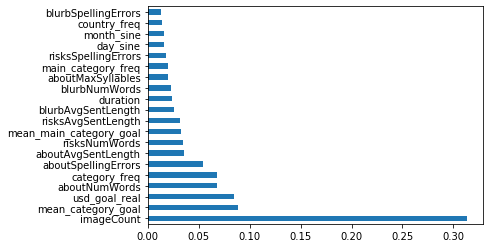

In [14]:
clf=call_randomforest_classify(trainValues,targetValues)
print(accuracy_score(clf.predict(trainValues),targetValues))
print(accuracy_score(clf.predict(testValues),testTargetValues))

feat_importances = pd.Series(clf.feature_importances_, index=trainValues.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [15]:
clf=call_gradientboosting_classfy(trainValues,targetValues)
print(accuracy_score(clf.predict(trainValues),targetValues))
print(accuracy_score(clf.predict(testValues),testTargetValues))



0.880165438520445
0.8786302557433897


1.0
0.8331166016471608


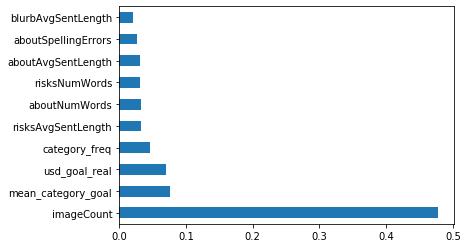

In [16]:
clf=call_decisiontrees_classify(trainValues,targetValues)
print(accuracy_score(clf.predict(trainValues),targetValues))
print(accuracy_score(clf.predict(testValues),testTargetValues))

feat_importances = pd.Series(clf.feature_importances_, index=trainValues.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [17]:
corrs,features=pearson_correlation(trainValues,targetValues)
sort_order = np.argsort(-np.absolute(corrs))
for i in sort_order:
    print(features[i],corrs[i])

mean_category_goal -0.2919022823975168
category_freq 0.2717792856483708
imageCount 0.2710236195272028
usd_goal_real -0.23487079319003418
aboutNumWords 0.20427092507875788
mean_main_category_goal -0.16516529482585424
duration -0.14736192254727792
aboutSpellingErrors 0.11337859075507255
aboutMaxSyllables 0.09349566261548439
main_category_freq 0.08497888081298965
risksNumWords 0.06929734429387681
risksAvgSentLength 0.06009098752668053
country_freq 0.05776203801866878
aboutAvgSentLength 0.04771053616587202
blurbAvgSentLength 0.04062141594052552
month_sine 0.03147055593301595
day_sine 0.023566706966740812
blurbSpellingErrors 0.018655163440790323
blurbNumWords 0.015649028044213146
risksSpellingErrors 0.010917335891929465


In [18]:
scores,features=chi_square(np.abs(trainValues),targetValues)
sort_order = np.argsort(-np.absolute(scores))
for i in sort_order:
    print(scores[i],features[i])

1536934.7623864503 aboutNumWords
106261.97530168884 imageCount
50746.82185431858 aboutSpellingErrors
27518.71585727505 risksNumWords
4605.691488916809 duration
1080.6839067004425 usd_goal_real
714.1793885794988 aboutMaxSyllables
695.1083350593019 mean_category_goal
423.1171553057104 risksAvgSentLength
344.5696081705401 aboutAvgSentLength
148.50258522207577 mean_main_category_goal
146.0719275830084 risksSpellingErrors
68.29176924659635 blurbAvgSentLength
38.884332442102895 blurbSpellingErrors
29.916597127765066 country_freq
18.062003331522114 blurbNumWords
11.815101130287722 category_freq
8.320395570212977 main_category_freq
2.7404657276691275 month_sine
0.4298337136044145 day_sine


In [ ]:
sklearn_lda = LDA(n_components=10)
X_lda_sklearn = sklearn_lda.fit_transform(trainValues,targetValues)

In [ ]:
X_lda_sklearn

In [38]:
# data.describe()
trainValues.describe()

,usd_goal_real,imageCount,category_freq,main_category_freq,country_freq,month_sine,day_sine,yes_video,duration,mean_category_goal,mean_main_category_goal,creator_successful,blurbNumWords,blurbAvgSentLength,blurbMaxSyllables,blurbSpellingErrors,aboutNumWords,aboutAvgSentLength,aboutMaxSyllables,aboutSpellingErrors,risksNumWords,risksAvgSentLength,risksMaxSyllables,risksSpellingErrors
count,55368.000000,55368.000000,55368.000000,55368.000000,55368.000000,5.536800e+04,55368.000000,55368.000000,55368.000000,55368.000000,55368.000000,55368.000000,55368.000000,55368.000000,55368.000000,55368.000000,55368.000000,55368.000000,55368.000000,55368.000000,55368.000000,55368.000000,55368.000000,55368.000000
mean,8.390381,15.366638,0.011361,0.094209,0.549581,-2.885960e-02,0.079812,0.735822,30.978435,9.792334,10.162967,1.105621,22.029891,9.244124,3.552666,1.317187,715.689604,21.889142,5.795730,24.690597,124.036230,17.313403,4.322045,3.622056
std,1.723002,20.037601,0.005729,0.044277,0.298335,7.188248e-01,0.703649,0.440898,10.893474,1.201175,0.999615,2.556870,5.417217,2.628673,0.998151,1.630371,690.014186,7.735939,2.924427,41.957893,113.304269,6.053223,1.240585,8.954035
min,0.553885,0.000000,0.000014,0.021370,0.000101,-1.000000e+00,-0.974928,0.000000,0.000000,7.586130,8.820326,0.000000,1.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,1.000000,0.000000
25%,7.313887,4.000000,0.006531,0.048866,0.114246,-8.660254e-01,-0.433884,0.000000,29.000000,8.874149,9.129817,0.000000,19.000000,7.500000,3.000000,0.000000,253.000000,17.738872,5.000000,7.000000,57.000000,13.600000,4.000000,1.000000
50%,8.517393,8.000000,0.011920,0.110302,0.730588,-2.449294e-16,0.433884,1.000000,29.000000,9.502993,10.219383,1.000000,23.000000,9.000000,3.000000,1.000000,499.000000,21.069136,5.000000,15.000000,96.000000,17.000000,4.000000,2.000000
75%,9.471318,18.000000,0.015908,0.143130,0.730588,5.000000e-01,0.781831,1.000000,32.000000,10.766550,10.925803,1.000000,26.000000,11.000000,4.000000,2.000000,945.000000,24.947368,6.000000,28.000000,157.000000,20.600000,5.000000,4.000000
max,18.835409,332.000000,0.021760,0.151582,0.730588,1.000000e+00,0.974928,1.000000,89.000000,14.214930,11.600327,51.000000,44.000000,18.500000,30.000000,16.000000,9411.000000,342.166667,180.000000,1354.000000,5703.000000,131.500000,47.000000,547.000000


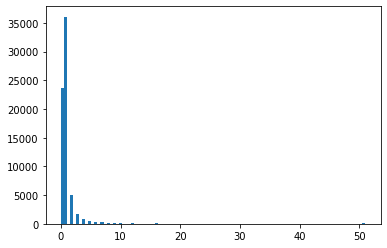

In [39]:
plt.hist(data['creator_successful'],bins=100)
plt.show()

([array([  1.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   4.,   1.,
           3.,   0.,   3.,   2.,   1.,   2.,   5.,   3.,   5.,   8.,   5.,
          11.,  12.,  25.,  22.,  30.,  23.,  22.,  33.,  47.,  62.,  79.,
          68.,  80., 166., 149., 148., 164., 179., 234., 211., 213., 251.,
         307., 285., 330., 357., 338., 359., 307., 485., 360., 315., 327.,
         322., 316., 257., 255., 214., 215., 162., 179., 151., 120.,  89.,
         102.,  81.,  78.,  56.,  36.,  38.,  53.,  26.,  30.,  21.,  18.,
          18.,  11.,  11.,  11.,  14.,   9.,  10.,   7.,   5.,   2.,   3.,
           7.,   1.,   0.,   3.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
           2.]),
  array([2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
         1.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 6.000e+00, 7.000e+00,
         1.000e+01, 1.600e+01, 1.000e+01, 8.000e+00, 1.900e+01, 2.200e+01,
         1.000e+01, 3.300e+01, 3.100e+01, 2.900e+01, 2.400e+01, 3.000e+01,
        

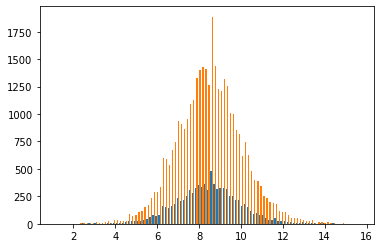

In [32]:
success1 = test[test.state==1]
success2 = train[train.state==1]
len(success)
plt.hist([success1['usd_pledged_real'],success2['usd_pledged_real']],bins=100)
# plt.hist(,bins=100)
# trainValues=train.drop(['state','usd_pledged_real'],axis=1)
# targetValues=train['usd_pledged_real']
# testValues=test.drop(['state','usd_pledged_real'],axis=1)
# testTargetValues=test['usd_pledged_real']
# testGoals=test['usd_goal_real']
# plt

(array([7.3000e+03, 1.0800e+03, 2.8370e+03, 4.2100e+03, 5.1550e+03,
        3.8650e+03, 3.9254e+04, 3.9720e+03, 8.4300e+02, 2.8400e+02,
        1.1300e+02, 5.6000e+01, 3.4000e+01, 1.5000e+01, 1.8000e+01,
        1.2000e+01, 1.0000e+01, 1.4000e+01, 5.0000e+00, 4.0000e+00,
        1.2000e+01, 5.0000e+00, 2.0000e+00, 2.0000e+00, 6.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00,
        3.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 0.0000e+00,
        2.0000e+00, 3.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00,
        2.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        2.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00,
        1.0000e+00, 1.0000e+00, 6.0000e+00, 3.0000e+00, 0.0000e+00,
        3.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00,
        2.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 0.0000e+00, 2.0000e+00, 3.00

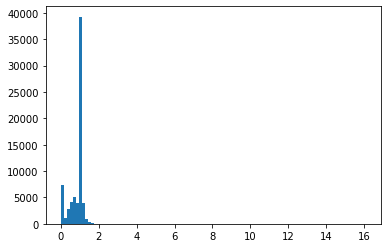

In [33]:
plt.hist(np.divide(filtered_data['usd_pledged_real'],filtered_data['usd_goal_real']),bins=100)

(array([6.9203e+04, 3.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([    0.  ,  6876.41, 13752.82, 20629.23, 27505.64, 34382.05,
        41258.46, 48134.87, 55011.28, 61887.69, 68764.1 ]),
 <a list of 10 Patch objects>)

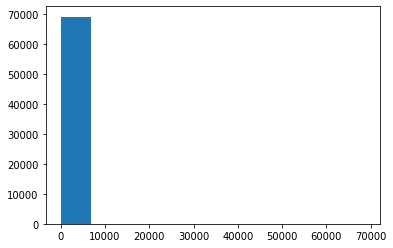

In [43]:
plt.hist(np.divide((data['usd_pledged_real']),(data['usd_goal_real'])))

In [42]:
# clf=call_gradientboosting_reg(trainValues,targetValues)
# pred=clf.predict(testValues)
# predictions=np.sign(pred-testGoals)clf=call_gradientboosting_reg(trainValues,targetValues)
# pred=clf.predict(testValues)
# predictions=np.sign(pred-testGoals)
# actuals=np.sign(testTargetValues-testGoals)
# print(accuracy_score(predictions,actuals))
# # print(accuracy_score(clf.predict(testValues),testTargetValues))
# actuals=np.sign(testTargetValues-testGoals)
# print(accuracy_score(predictions,actuals))
# # print(accuracy_score(clf.predict(testValues),testTargetValues))